In [1]:
"""
This set of functions allows the user to compute a stream using the particle spray
using the jacobi radius and using Galpy
"""
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014 as MW14
from galpy.potential.mwpotentials import McMillan17 as MW17
from galpy.util import conversion
from galpy.potential import evaluatePotentials, mass
import numpy as np 
import matplotlib.pyplot as plt 
import h5py 
import sys 
sys.path.append("/home/sferrone/GC-tidal-loss/simulations/analytic-GC-tidal-loss/code")
import inputMW
import inputGC
import os
import orbitCoords as OC
import astropy.coordinates as coord
import astropy.units as u
import multiprocessing as mp
import trace_orbit as TO

A new version of galpy (1.8.2) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


In [2]:
plt.style.use('dark_background')

In [3]:
def calcJacobii(laX,laY,laZ,satmass):
    """ CALCULATE THE THEORHETICAL JACOBI RADIUS from PII
    For a satelite orbiting the galactic center
    assuming, fasly, in a spherically symmetric potential
    SATMASS ALREADY IN SOLAR MASSES PLEASE
    
    """
    G=1
    TOSOLAR=2.32*10**7
    ax,ay,az,_=inputMW.potMW(laX,laY,laZ,0,"PII")
    nabPhi=np.sqrt(ax**2 + ay**2 + az**2)
    r = np.sqrt(laX**2 + laY**2 + laZ**2)
    MASS = nabPhi*(r**2)*G*TOSOLAR
    jacobii=2.88 * ((satmass/MASS)**(1/3))*r 
    return jacobii

def Jacobii(Pot,R,z,satmass,conv):
    """ CALCULATE THE THEORHETICAL JACOBI RADIUS
    SATMASS IN SOLAR MASSES PLEASE
    """
    massEnc=np.abs(mass(Pot,R,z)*conversion.mass_in_msol(conv['ro'],conv['vo']))
    r = np.sqrt(R**2 + z**2)
    rJAC=2.88*((satmass/massEnc)**(1/3))*r 
    return rJAC

In [4]:
def cyl_to_cart(cylin):
    """
    cylin=[R, vR, vT, z, vZ, phi]
    """
    R, vR, vT, z, vZ, phi=cylin[0],cylin[1],cylin[2],cylin[3],cylin[4],cylin[5]
    x,y=R*np.cos(phi),R*np.sin(phi)
    Rvec=np.array([x,y,0])
    Rmax=np.linalg.norm(Rvec)
    Runit=Rvec/Rmax 
    tanUnit=np.cross([0,0,1],Runit)
    VZ = np.array([0,0,vZ])
    VR = vR*Runit
    VT = vT*tanUnit
    vel=VZ+VR+VT
    return np.array([x,y,z,vel[0],vel[1],vel[2]])



In [5]:
def escapeInitialConditions(R, vR, vT, z, vZ, escapFunc, phi,satmass,conv):
    """
    SAT MASS ALREADY IN SOLAR 
    insert the coordinates of progenitor in natural units
    return the kinematics at the escape points in galpy format and in "natural" units
    assumes co-motion of the progenitor ie. forward moving orbit in time
    the interior and exterior escape particles have the same velocity as the GC
    escapFunc: a function used to calculate the escape radius. For now calcJacobii is supported
    """
    
    laX,laY=conv['ro']*R*np.cos(phi),conv['ro']*R*np.sin(phi)
    lat=np.arcsin(z/np.sqrt(R**2 + z**2))
    if escapFunc==calcJacobii:
        jacobii=escapFunc(laX,laY,conv['ro']*z,satmass)/conv['ro']
    if escapFunc==Jacobii:
        jacobii=Jacobii(MW14,R,z,satmass,conv)
    rint = np.sqrt(R**2 + z**2) - jacobii
    rext = np.sqrt(R**2 + z**2) + jacobii
    Rint,zint=rint*np.cos(lat),rint*np.sin(lat)
    Rext,zext=rext*np.cos(lat),rext*np.sin(lat)
    interior = [Rint,vR,vT,zint,vZ,phi]
    exterior = [Rext,vR,vT,zext,vZ,phi]
    return interior,exterior


In [6]:
def cart_to_cylin(COM):
    """
    position and velocities to cylindrical in the galpy calling sequence
    return these with units
    """ 
    vel=np.array([COM.v_x.value, COM.v_y.value, COM.v_z.value])
    RR = np.array([COM.x.value, COM.y.value,0])
    R=np.sqrt (COM.x**2 + COM.y**2)
    magR = np.linalg.norm(RR)*u.kpc
    RUnit = RR/np.linalg.norm(RR) # cannot use "Quantity" 
    zUnit=[0,0,1]
    tanUnit=np.cross(zUnit,RUnit)
    # project velocity onto these axis and re-add units so that they are "Qauntity" objs
    vT=np.dot(vel,tanUnit)*u.km/u.s
    vR=np.dot(vel,RUnit)*u.km/u.s
    vZ=np.dot(vel,[0,0,1])*u.km/u.s    
    phi = np.arctan2(COM.y,COM.x)
    phi=phi.value*(180/np.pi)*u.degree
    return R,vR,vT,COM.z,vZ,phi


In [7]:
def particleSpray(ts,fullorbit,satmass,conv,escapFunc):
    """ 
    All in natural units. 
    find the final positions of the particles that escape from the time stamps given by ts
    
    ts must be the N//2 where N is the length of full orbit

    escapFunc = a function that takes in the kinematics and and such and returns the kinematics of the particles at the escape points
    """
    N = ts.shape[0]
    leadingF=np.zeros((N-1,6))
    trailingF=np.zeros((N-1,6))
    tf=ts[-1]
    for i in range(N-1):
        R, vR, vT, z, vZ, phi = fullorbit[i,:]
        interior,exterior=escapeInitialConditions(R, vR, vT, z, vZ, escapFunc, phi,satmass,conv)
        intOrb=Orbit(interior)
        extOrb=Orbit(exterior)
        inttime=np.linspace(0,tf-ts[i],N-i)
        intOrb.integrate(inttime,MW14)
        extOrb.integrate(inttime,MW14)
        leadingF[i,:]=intOrb.getOrbit()[-1,:]
        trailingF[i,:]=extOrb.getOrbit()[-1,:]
    return leadingF, trailingF    


In [8]:
def makeoutpath(C):
    """
    Given the config with all of out information..
    """
    path="../../outputDATA/"
    os.makedirs(path,exist_ok=True)
    path+=C['dataset']+"/"
    os.makedirs(path,exist_ok=True)   
    path+=C["MWpoten"]+"/"
    os.makedirs(path,exist_ok=True)   
    path+=C["GCpoten"]+"/"
    os.makedirs(path,exist_ok=True)   
    path+="T-"+str(C['T'])+"/"
    os.makedirs(path,exist_ok=True)   
    path+="backward/"
    os.makedirs(path,exist_ok=True)   
    path+="streams/"
    os.makedirs(path,exist_ok=True)   
    path+="Np-"+str(C["Np"])+"/"
    os.makedirs(path,exist_ok=True)   
    return path

## let us work on the orbit. What should I have?


Text(0, 0.5, 'z (kpc)')

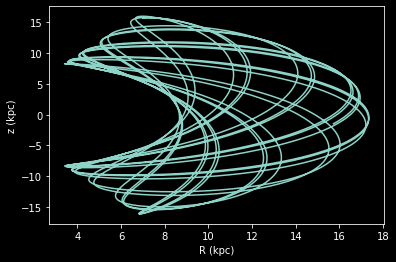

In [9]:
GCname="Pal5"
backpath="/mod4gaia/GCsTT/EDR3/outputDATA/PII/backwardorbits/orbitPal5.dat"
orb=np.loadtxt(backpath)
R=np.sqrt(orb[:,1]**2 + orb[:,2]**2)
plt.plot(R,orb[:,3])
plt.xlabel("R (kpc)")
plt.ylabel("z (kpc)")

In [10]:
N=1000
tau=50
GCname="Pal5"
C={}
C["dataset"]="EDR3"
C["MWpoten"]="Bovy2014" # MWPotential2014
C["GCpoten"]="PSpray"
C["Nstep"] = N 
C['deltat'] = None
C['Np'] = N-1
C["T"] = tau
C["comment"] = "the integration time is in 100 Myrs"
outpath=makeoutpath(C)

### CONVERT TIME FROM PHYSICAL UNITS TO GALPY UNITS 

the target amount of time

In [11]:
inttime= 5*u.Gyr

now load in an orbit

In [12]:
# load orbit conditions
COM=OC.getCOM(GCname)
params=inputGC.Plummer(GCname)
R,vR,vT,z,vZ,phi=cart_to_cylin(COM)
orbB=Orbit([R,-vR,-vT,z,-vZ,phi])
orbF=Orbit([R,vR,vT,z,vZ,phi])

get the galpy converstion object

In [13]:
conv=conversion.get_physical(orbB)

find the time units for this potential

$\tau$= $ R_o/ v_o$

In [14]:
tgalpy=(conv['ro']*u.kpc) / (conv['vo']*(u.km/u.s))
print(tgalpy)

0.03636363636363636 kpc s / km


convert to years

In [15]:
tgalpy.to(u.yr)
print(tgalpy.to(u.Gyr))

0.035556080788392334 Gyr


now find the total orbital time in the galy units

In [16]:
print(inttime.to(u.yr))

5000000000.0 yr


In [17]:
galInttime = inttime.to(u.yr)/tgalpy.to(u.yr)
print(galInttime.value)

140.62292269378307


In [18]:
ts=np.linspace(0,galInttime.value,N)

do the integration 

In [19]:
orbB.integrate(ts,MW14)
orbF.integrate(ts,MW14)
# construct the full orbit
borbit=orbB.getOrbit()
forbit=orbF.getOrbit()

plot the orbit

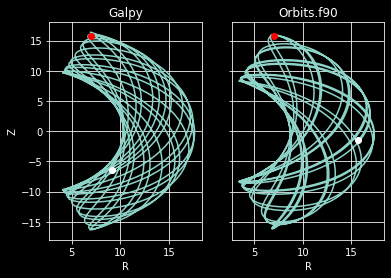

In [20]:
fig,ax=plt.subplots(1,2,sharex=True,sharey=True)
ax[0].plot(borbit[:,0]*conv['ro'],borbit[:,3]*conv['ro'])
ax[0].set_xlabel("R")
ax[0].set_ylabel("Z")

ax[1].plot(np.sqrt(orb[:,1]**2 + orb[:,2]**2),orb[:,3])
ax[1].set_xlabel("R")
ax[0].set_title("Galpy")
ax[1].set_title("Orbits.f90")
ax[1].grid(True)
ax[0].grid(True)

ax[0].scatter(borbit[0,0]*conv['ro'],borbit[0,3]*conv['ro'],c='r',zorder=10)
ax[0].scatter(borbit[-1,0]*conv['ro'],borbit[-1,3]*conv['ro'],c='w',zorder=10)
ax[1].scatter(np.sqrt(orb[0,1]**2 + orb[0,2]**2),orb[0,3],c='r',zorder=10)
ax[1].scatter(np.sqrt(orb[-1,1]**2 + orb[-1,2]**2),orb[-1,3],c='w',zorder=10)

white is the end point in the backward integration. The red point is the initial condition. So interestingly we see how much the assumption of the galactic potential model changes the orbit as well as the position as a function of time


now we will plot the time series as a check of the 3D radius

In [21]:
r3Dgalpy = np.flip(np.sqrt(borbit[:,0]**2 + borbit[:,3]**2 ))*conv['ro']
r3Df90   = np.flip(np.sqrt(orb[:,1]**2 + orb[:,2]**2 + orb[:,3]**2 ))

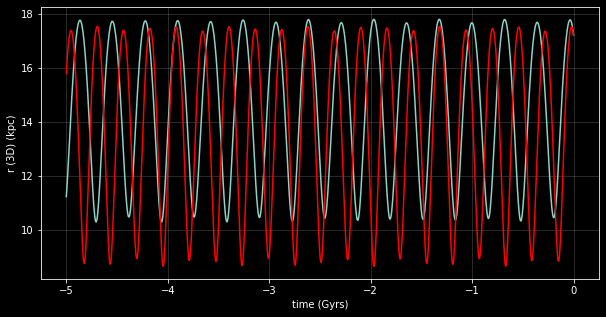

In [22]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
ax.plot(ts*tgalpy.to(u.Gyr) -5*u.Gyr,r3Dgalpy)
ax.plot(orb[:,0]/10 -5 ,r3Df90,c='r')

ax.set_xlabel("time (Gyrs)")
ax.set_ylabel("r (3D) (kpc)")
ax.grid(True,alpha=0.2)

### Now focus on the particle spray

what about where the particles are being released from?

In [23]:
from galpy.potential import MWPotential2014 as MW14
from galpy.potential import mass
R=1.6303380979868902
z=1.2732319411637634
print(mass(MW14,R,z),mass(MW14,R,-z))

1.3924105988548559 -1.3924105988548559


beware of this bug ! No negative mass!

Now flip the backward orbit to go forward

In [24]:
borbit=orbB.getOrbit()
borbit=np.flipud(borbit)
borbit[:,[1,2,4]]*=-1 # switch the direction of the velocity

convert GC mass to solar masses

In [25]:
TOSOLAR=2.32*10**7 # from our simulation
satmass=params[0]*TOSOLAR

initialize the output

In [26]:
iOUT = np.zeros((N,6))
eOUT = np.zeros((N,6))
fullorbit=np.concatenate((borbit[:-1,:],forbit))

calculate the jacboii radius

In [27]:
i=6
rJAC=Jacobii(MW14,borbit[i,0],borbit[i,3],satmass,conv)
print("Bovy2014", rJAC*conv['ro'],'kpc')

Bovy2014 0.597178938693594 kpc


find initial conditions of the orbit of two particles escaping at the jacobbi radius

In [28]:
R, vR, vT, z, vZ, phi = borbit[i,:]
interior,exterior=escapeInitialConditions(R, vR, vT, z, vZ, Jacobii, phi,satmass,conv)
for j in range(len(interior)):
    print(interior[j],borbit[i,j],exterior[j])

1.568494606298945 1.6427540501841527 1.7170134940693602
0.40985112412699637 0.40985112412699637 0.40985112412699637
-0.3427554020758182 -0.3427554020758182 -0.3427554020758182
-0.16053200738025752 -0.16813229975356894 -0.17573259212688036
0.8450112630542311 0.8450112630542311 0.8450112630542311
-0.15607994882217519 -0.15607994882217519 -0.15607994882217519


seems to check out. plot them

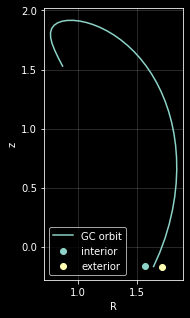

In [29]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(borbit[i:i+40,0],borbit[i:i+40,3],label="GC orbit")
ax.scatter(interior[0],interior[3],label="interior")
ax.scatter(exterior[0],exterior[3],label="exterior")
ax.set_xlabel("R")
ax.set_ylabel("z")
ax.legend()
ax.set_aspect("equal")
ax.grid(True,alpha=0.2)

now calculate the orbit for these two points

In [30]:
ip=Orbit(interior)
ep=Orbit(exterior)

set up the points at which we evaluate the orbit. The starting point is now and the end point is the same as orbB

In [31]:
teval = np.array([ts.max(), ts[i]])

In [32]:
ip.integrate(teval,MW14,)
ep.integrate(teval,MW14,)

store these final positions

In [33]:
iOUT[i,:] = ip.getOrbit()[-1,:]
eOUT[i,:] = ep.getOrbit()[-1,:]

view the final positions

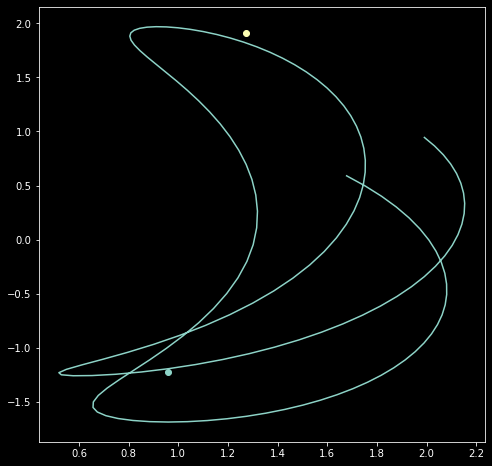

In [34]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
shift=75
mask=iOUT[:,0]!=0
downDEX,upDEX = N-shift,N+shift
ax.plot(fullorbit[downDEX:upDEX,0],fullorbit[downDEX:upDEX,3])
ax.scatter(iOUT[mask,0],iOUT[mask,3])
ax.scatter(eOUT[mask,0],eOUT[mask,3])

In [35]:
iOUT = np.zeros((N,6))
eOUT = np.zeros((N,6))

In [36]:
# def PSpray(pot,lorbit,satmass,conv,orbtime):
#     """
#     """
lorbit=borbit
pot=MW14
orbtime=ts

N = lorbit.shape[0]
# iOUT = np.zeros((N,6))
# eOUT = np.zeros((N,6))
# for i in range(N):
for i in range(50):
    R, vR, vT, z, vZ, phi = lorbit[i,:]
    interior,exterior=escapeInitialConditions(R, vR, vT, z, vZ, Jacobii,phi,satmass,conv)
    if i==N-1:
        iOUT=interior
        eOUT=exterior
    else:
        ip=Orbit(interior)
        ep=Orbit(exterior)
        teval = np.array([orbtime.max(), orbtime[i]])
        ip.integrate(teval,pot,)
        ep.integrate(teval,pot,)
        iOUT[i,:] = ip.getOrbit()[-1,:]
        eOUT[i,:] = ep.getOrbit()[-1,:]
    # return iOUT,eOUT

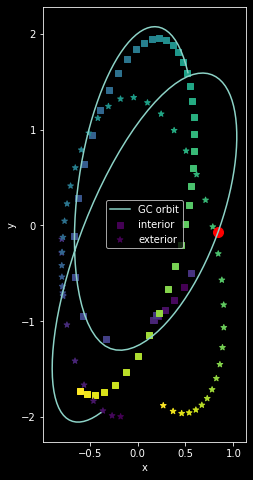

In [37]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
shift=75
mask=iOUT[:,0]!=0
downDEX,upDEX = N-shift,N+shift

xORB = fullorbit[downDEX:upDEX,0]*np.cos(fullorbit[downDEX:upDEX,5])
yORB = fullorbit[downDEX:upDEX,0]*np.sin(fullorbit[downDEX:upDEX,5])
xINT = iOUT[mask,0]*np.cos(iOUT[mask,5])
yINT = iOUT[mask,0]*np.sin(iOUT[mask,5])
xEXT = eOUT[mask,0]*np.cos(eOUT[mask,5])
yEXT = eOUT[mask,0]*np.sin(eOUT[mask,5])

ax.plot(xORB,yORB,label="GC orbit")
ax.scatter(xINT,yINT,c=ts[mask],marker='s',label="interior")
ax.scatter(xEXT,yEXT,c=ts[mask],marker='*',label="exterior")
middex=int(len(xORB)/2)
ax.scatter(xORB[middex],yORB[middex],c='r',s=100)
ax.set_aspect("equal")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect("equal")
ax.legend()

### COMMENT

OK. These are the first 100 particles released starting 5 GYRS ago. this particle spary stream encircles the galactic pole to many times. So i'm going to only select a recent section of the backward orbit for this computation 

In [82]:
def PSpray(pot,lorbit,satmass,conv,orbtime):
    """docstring for PSpray
    pot: potential
    lorbit : portion of an orbit moving forward in time with increase index
    satmass : the mass of the satellite in solar masses
    conv : dictionary of conversion factors
    orbtime : time array of the orbit starting at zero and moving forward in time
    """
    N = lorbit.shape[0]
    iOUT = np.zeros((N,6))
    eOUT = np.zeros((N,6))
    for i in range(N):
    # for i in range(50):
        R, vR, vT, z, vZ, phi = lorbit[i,:]
        interior,exterior=escapeInitialConditions(R, vR, vT, z, vZ, Jacobii,phi,satmass,conv)
        if i==N-1:
            iOUT[i,:]=interior
            eOUT[i,:]=exterior
        else:
            ip=Orbit(interior)
            ep=Orbit(exterior)
            teval = np.array([orbtime.max(), orbtime[i]])
            ip.integrate(teval,pot,)
            ep.integrate(teval,pot,)
            iOUT[i,:] = ip.getOrbit()[-1,:]
            eOUT[i,:] = ep.getOrbit()[-1,:]
    return iOUT,eOUT

### calculate a new backward orbit only 0.5 Gyr in the past 

In [83]:
N = 1000
inttime=0.1*u.Gyr
galInttime = inttime.to(u.yr)/tgalpy.to(u.yr)
ts=np.linspace(0,galInttime.value,N)
# load orbit conditions
COM=OC.getCOM(GCname)
params=inputGC.Plummer(GCname)
R,vR,vT,z,vZ,phi=cart_to_cylin(COM)
orbB=Orbit([R,-vR,-vT,z,-vZ,phi])
orbF=Orbit([R,vR,vT,z,vZ,phi])

In [84]:
orbB.integrate(ts,MW14)
orbF.integrate(ts,MW14)

In [85]:
borbit=orbB.getOrbit()
borbit=np.flipud(borbit)
borbit[:,[1,2,4]]*=-1 

In [86]:
intStr,extStr=PSpray(MW14,borbit,satmass,conv,ts)

In [104]:
lorbit=borbit   

N = lorbit.shape[0]
iOUT = np.zeros((N,6))
eOUT = np.zeros((N,6))
for i in range(N):
# for i in range(50):
    R, vR, vT, z, vZ, phi = lorbit[i,:]
    interior,exterior=escapeInitialConditions(R, vR, vT, z, vZ, Jacobii,phi,satmass,conv)
    if i==N-1:
        iOUT[i,:]=interior
        eOUT[i,:]=exterior
    else:
        ip=Orbit(interior)
        ep=Orbit(exterior)
        teval = np.array([orbtime.max(), orbtime[i]])
        ip.integrate(teval,pot,)
        ep.integrate(teval,pot,)
        iOUT[i,:] = ip.getOrbit()[-1,:]
        eOUT[i,:] = ep.getOrbit()[-1,:]


In [87]:
fullorbit=np.concatenate((borbit[:-1,:],forbit))

In [102]:

okok=ip.getOrbit()
okok1=ep.getOrbit()
xp=okok[:,0]*np.cos(okok[:,5])
yp=okok[:,0]*np.sin(okok[:,5])
xp1=okok1[:,0]*np.cos(okok1[:,5])
yp1=okok1[:,0]*np.sin(okok1[:,5])

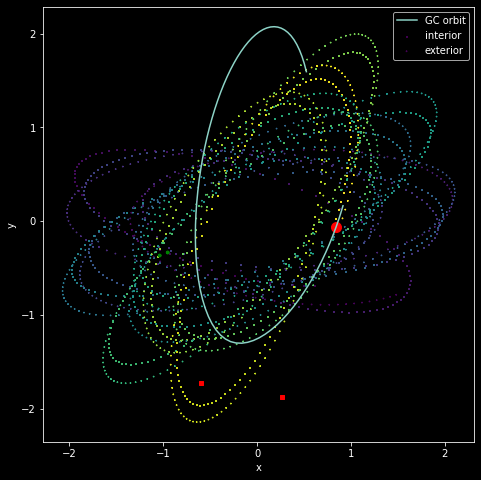

In [105]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
shift=75
mask=iOUT[:,0]!=0
downDEX,upDEX = N-shift,N+shift

xORB = fullorbit[downDEX:upDEX,0]*np.cos(fullorbit[downDEX:upDEX,5])
yORB = fullorbit[downDEX:upDEX,0]*np.sin(fullorbit[downDEX:upDEX,5])
xINT = iOUT[mask,0]*np.cos(iOUT[mask,5])
yINT = iOUT[mask,0]*np.sin(iOUT[mask,5])
xEXT = eOUT[mask,0]*np.cos(eOUT[mask,5])
yEXT = eOUT[mask,0]*np.sin(eOUT[mask,5])

ax.plot(xORB,yORB,label="GC orbit")
ax.scatter(xINT,yINT,c=ts[mask],marker='s',label="interior",s=1)
ax.scatter(xEXT,yEXT,c=ts[mask],marker='*',label="exterior",s=1)
middex=int(len(xORB)/2)
ax.scatter(xORB[middex],yORB[middex],c='r',s=100)
ax.scatter(xp[0],yp[0],c='g',s=10,marker=r'$\odot$')
ax.scatter(xp[1],yp[1],c='r',s=10,marker='s')

ax.scatter(xp1[0],yp1[0],c='g',s=10,marker=r'$\odot$')
ax.scatter(xp1[1],yp1[1],c='r',s=10,marker='s')

ax.set_aspect("equal")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect("equal")
ax.legend()

some thing is clearly wrong. It might be jupyer notebook. Put the functions in a module

In [ ]:
i=0
laX,laY=borbit[i,0]*np.cos(borbit[i,5]),borbit[i,0]*np.sin(borbit[i,5])
laZ=borbit[i,3]
laX,laY,laZ=conv['ro']*laX,conv['ro']*laY,conv['ro']*laZ
print(laX,laY,laZ)
r1=calcJacobii(laX,laY,laZ,satmass)
rJAC=Jacobii(MW14,borbit[i,0],borbit[i,3],satmass,conv)
print("PII", r1, 'kpc')
print("Bovy2014", rJAC*conv['ro'],'kpc')

In [134]:
stime=time.time()
leadingF, trailingF=particleSpray(ts,fullorbit,params[0],conv,Jacobii)
print(GCname, time.time()-stime)

Pal5 440.32915782928467


In [137]:
leadCart=np.zeros(leadingF.shape)
trailCart=np.zeros(trailingF.shape)
for i in range(leadingF.shape[0]):
    leadCart[i,:] = cyl_to_cart(leadingF[i,:])
    trailCart[i,:] = cyl_to_cart(trailingF[i,:])
x=np.concatenate((leadCart[:,0],trailCart[:,0]))*conv['ro']*u.kpc
y=np.concatenate((leadCart[:,1],trailCart[:,1]))*conv['ro']*u.kpc
z=np.concatenate((leadCart[:,2],trailCart[:,2]))*conv['ro']*u.kpc
vx=np.concatenate((leadCart[:,3],trailCart[:,3]))*conv['vo']*u.km/u.s
vy=np.concatenate((leadCart[:,4],trailCart[:,4]))*conv['vo']*u.km/u.s
vz=np.concatenate((leadCart[:,5],trailCart[:,5]))*conv['vo']*u.km/u.s


In [138]:
tsRealUnits = np.flip(ts[:-1]) * (conv['ro']/conv['vo'])
tEscOut=np.concatenate((tsRealUnits,tsRealUnits))
galacto=coord.SkyCoord(x=x,y=y,z=z,v_x=vx,v_y=vy,v_z=vz,frame=inputMW.ref_frame())
sky = galacto.transform_to(coord.ICRS)
galactic = sky.transform_to('galactic')

In [117]:
# junk code from before
## CALCULATE JACOBII USING PII POTENTIAL
laX,laY,laZ=conv['ro']*laX,conv['ro']*laY,conv['ro']*laZ
print(laX,laY,laZ)
r1=calcJacobii(laX,laY,laZ,satmass)

2.3134304415723124 5.135716787038126 31.40227953557968


In [174]:
escapetimes = np.concatenate((np.flip(ts[:-1]),np.flip(ts[:-1])))

In [215]:
streampath="/mod4gaia/GCsTT_website/PII/streams/Pal5.h5"
stream=h5py.File(streampath,'r')

In [216]:
COMlb=COM.transform_to('galactic')

In [235]:
R,vR,vT,z,vZ,phi=cart_to_cylin(COM)
Jacobii(MW14,R,z,satmass,conv)
interior,exterior=escapeInitialConditions(R, vR, vT, z, vZ, Jacobii, phi,satmass,conv)
xi,yi=interior[0]*np.cos(interior[5]),interior[0]*np.sin(interior[5])
xe,ye=exterior[0]*np.cos(exterior[5]),exterior[0]*np.sin(exterior[5])

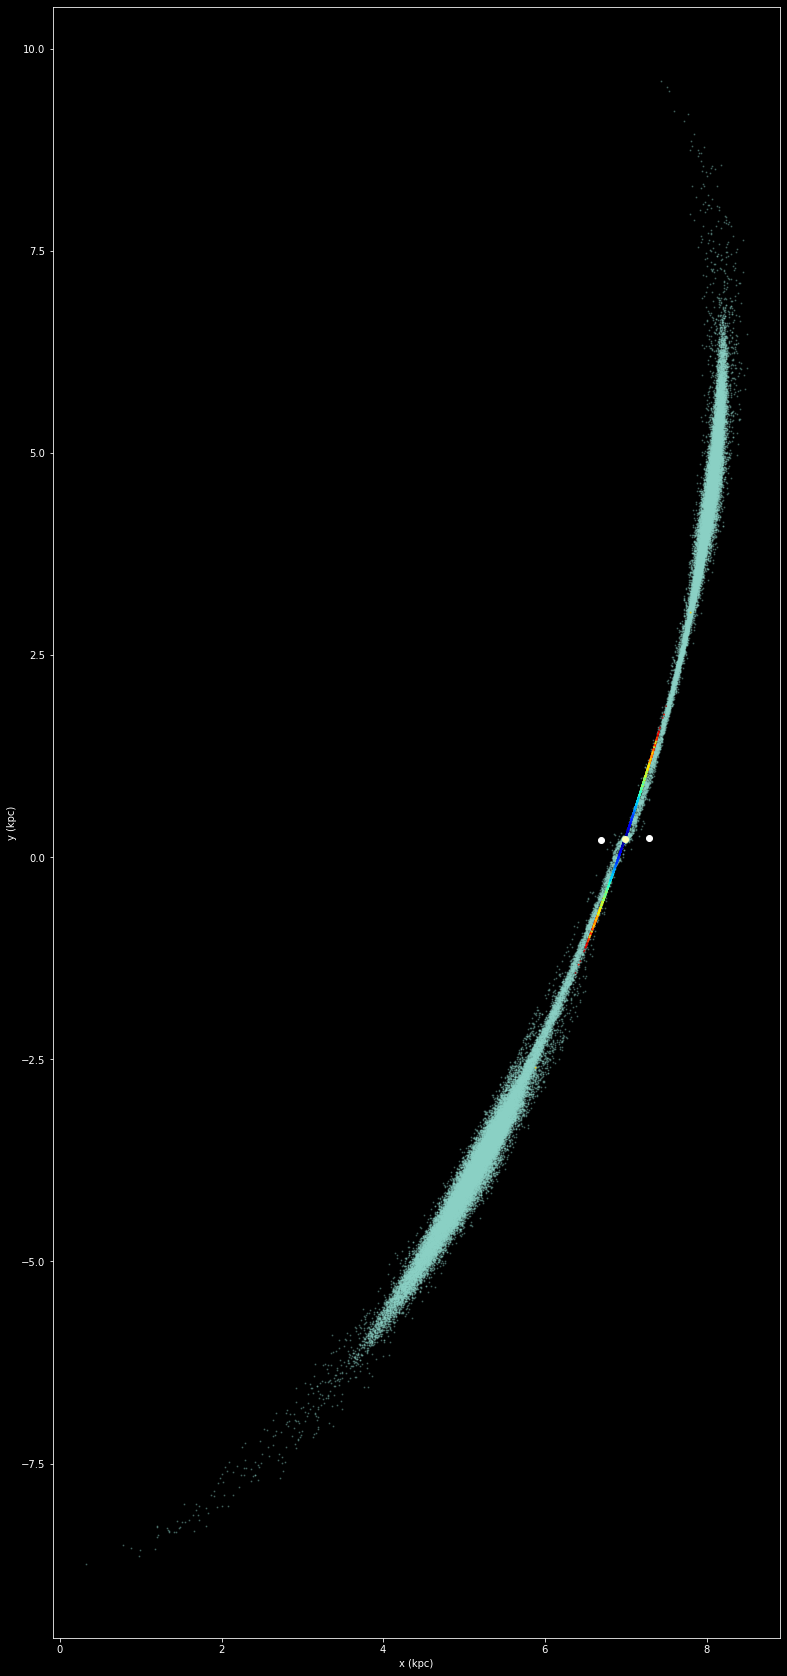

In [253]:
fig,ax=plt.subplots(1,1,figsize=(30,30))
ax.scatter(stream['galactocentric']['X'][:],stream['galactocentric']['Y'][:],s=1,alpha=0.3)
ax.scatter(galacto.x,galacto.y,c=escapetimes,s=1,alpha=0.7,cmap=plt.get_cmap("jet"))
ax.scatter(COM.x,COM.y)
ax.scatter(xi,yi, c='w')
ax.scatter(xe,ye, c='w')
ax.set_xlabel("x (kpc)")
ax.set_ylabel("y (kpc)")
ax.set_aspect('equal')

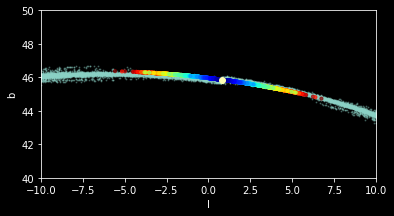

In [217]:
plt.style.use('dark_background')

fig,ax=plt.subplots(1,1)
ax.scatter(stream['galactic']['LONG'][:],stream['galactic']['LAT'][:],s=1,alpha=0.3)
ax.scatter(galactic.l.wrap_at(180*u.degree),galactic.b,c=escapetimes,s=10,alpha=0.7,cmap=plt.get_cmap("jet"))
ax.scatter(COMlb.l.wrap_at(180*u.degree),COMlb.b)
ax.set_xlabel("l")
ax.set_ylabel("b")
ax.set_xlim(-10,10)
ax.set_ylim(40,50)
ax.set_aspect('equal')

We're not doing well. It looks like the extend and y' are too small. 

why? let's debug

In [47]:
streampath="/mod4gaia/GCsTT_website/PII/streams/Pal5.h5"
stream=h5py.File(streampath,'r')

[1.6182002828203659, -0.31915985891102205, -0.3479433621660468, 1.4745650929618075, 0.49294596823539166, -0.5679081489145277]
[1.6183197155914468, -0.31915985891102205, -0.3479433621660468, 1.4746739246046279, 0.49294596823539166, -0.5679081489145277]
[ 1.61826    -0.31915986 -0.34794336  1.47461951  0.49294597 -0.56790815]
0.00047773108432735967


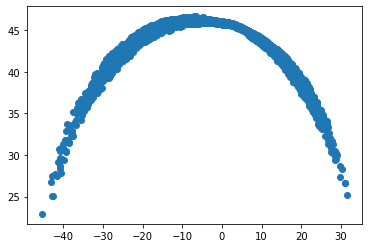

In [149]:
plt.scatter(stream['galactic']['LONG'][:],stream['galactic']['LAT'][:])

so this is what I should have

In [148]:
stream.keys()

<KeysViewHDF5 ['energy', 'equatorial', 'galactic', 'galactocentric']>

In [300]:
stream['energy']['Tescape'][:].max()

49.989000000000004